# How to run a Python function on a remote computer

## Introduction
`PythonJob` node is a built-in node, which allow user to run Python function on a remote computer.


Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.

In order to run the function on a remote computer, we need to set `on_remote` to `True` when adding the node.

In [5]:
from aiida_workgraph import node, WorkGraph

# define add node
@node()
def add(x, y):
    return x + y

# define multiply node
@node()
def multiply(x, y):
    return x*y


wg = WorkGraph("first_workflow")
wg.nodes.new("PythonJob", function=add, name="add")
wg.nodes.new("PythonJob", function=multiply, name="multiply", x=wg.nodes["add"].outputs[0])

# visualize the workgraph
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

### Submit the workgraph
We need to provide the `code` to the built-in `_code` input port.

WorkGraph node created, PK: 41813

Result of multiply is uuid: cb16a929-97ff-4638-9885-bc88159ede2e (pk: 41830) : 20 




/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


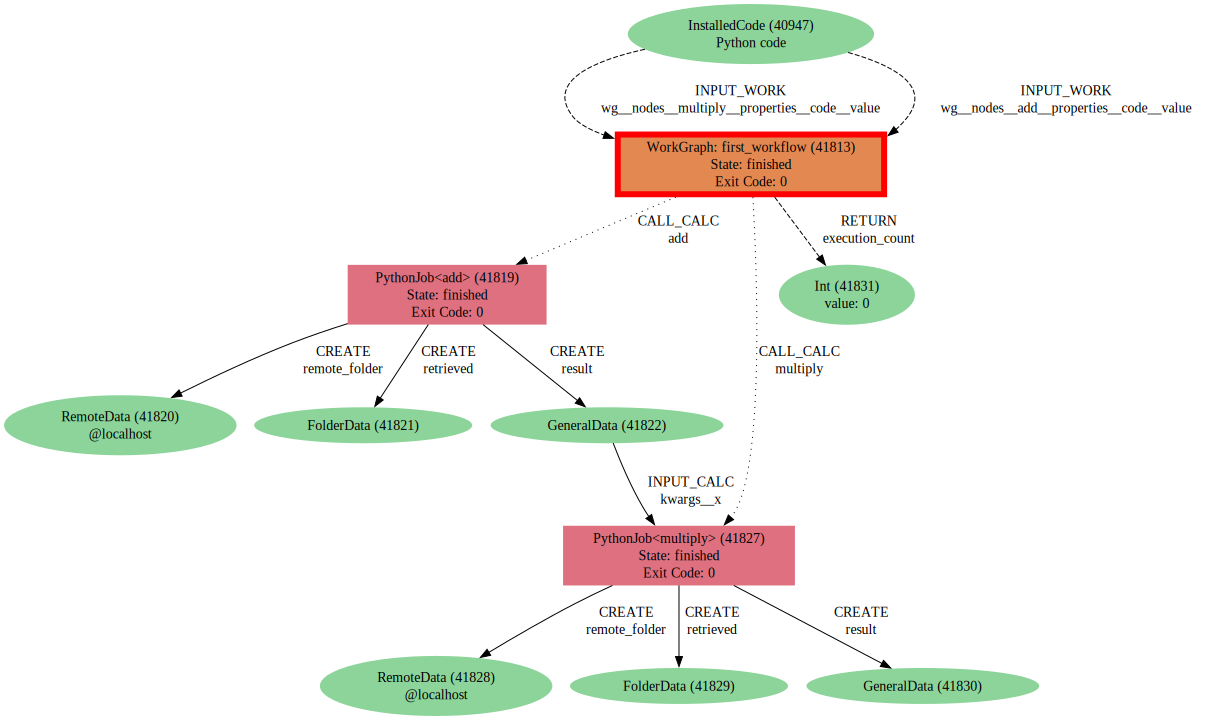

In [6]:
from aiida_workgraph.utils import generate_node_graph
from aiida.orm import load_code

code = load_code("python@localhost")

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "code": code},
                    "multiply": {"y": 4, "code": code}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Use parent folder


In [7]:
from aiida_workgraph import WorkGraph, node
from aiida import orm

# define add node
@node()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))
    return x + y

# define multiply node
@node()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("first_workflow")
wg.nodes.new("PythonJob", function=add, name="add")
wg.nodes.new("PythonJob", function=multiply, name="multiply",
             parent_folder=wg.nodes["add"].outputs["remote_folder"],
             )

#------------------------- Submit the calculation -------------------
code = orm.load_code("python@localhost")
wg.submit(inputs = {"add": {"x": 2, "y": 3, "code": code},
                    "multiply": {"x": 3, "y": 4, "code": code}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))

WorkGraph node created, PK: 41832

Result of multiply is uuid: a5f8c7ca-fd06-4c07-bb81-3910d8b63f38 (pk: 41850) : 17 




## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.


### Define a node to calculate the energy of the atoms using EMT potential

In [8]:
from aiida_workgraph import node, WorkGraph

@node()
def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return energy


@node()
def atomization_energy(mol, energy_molecule, energy_atom):
    energy = energy_atom*len(mol) - energy_molecule
    return energy


### Define a workgraph


In [10]:
wg = WorkGraph("atomization_energy")
pw_atom = wg.nodes.new("PythonJob", function=emt, name="emt_atom")
pw_mol = wg.nodes.new("PythonJob", function=emt, name="emt_mol")
# create the node to calculate the atomization energy
wg.nodes.new("PythonJob", function=atomization_energy, name="atomization_energy",
             energy_atom=pw_atom.outputs["result"],
             energy_molecule=pw_mol.outputs["result"])
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'atomiza…

### Prepare the inputs and submit the workflow

WorkGraph node created, PK: 41852
Energy of a N atom:                  3.952
Energy of an un-relaxed N2 molecule: 0.549
Atomization energy:                  7.354 eV


/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


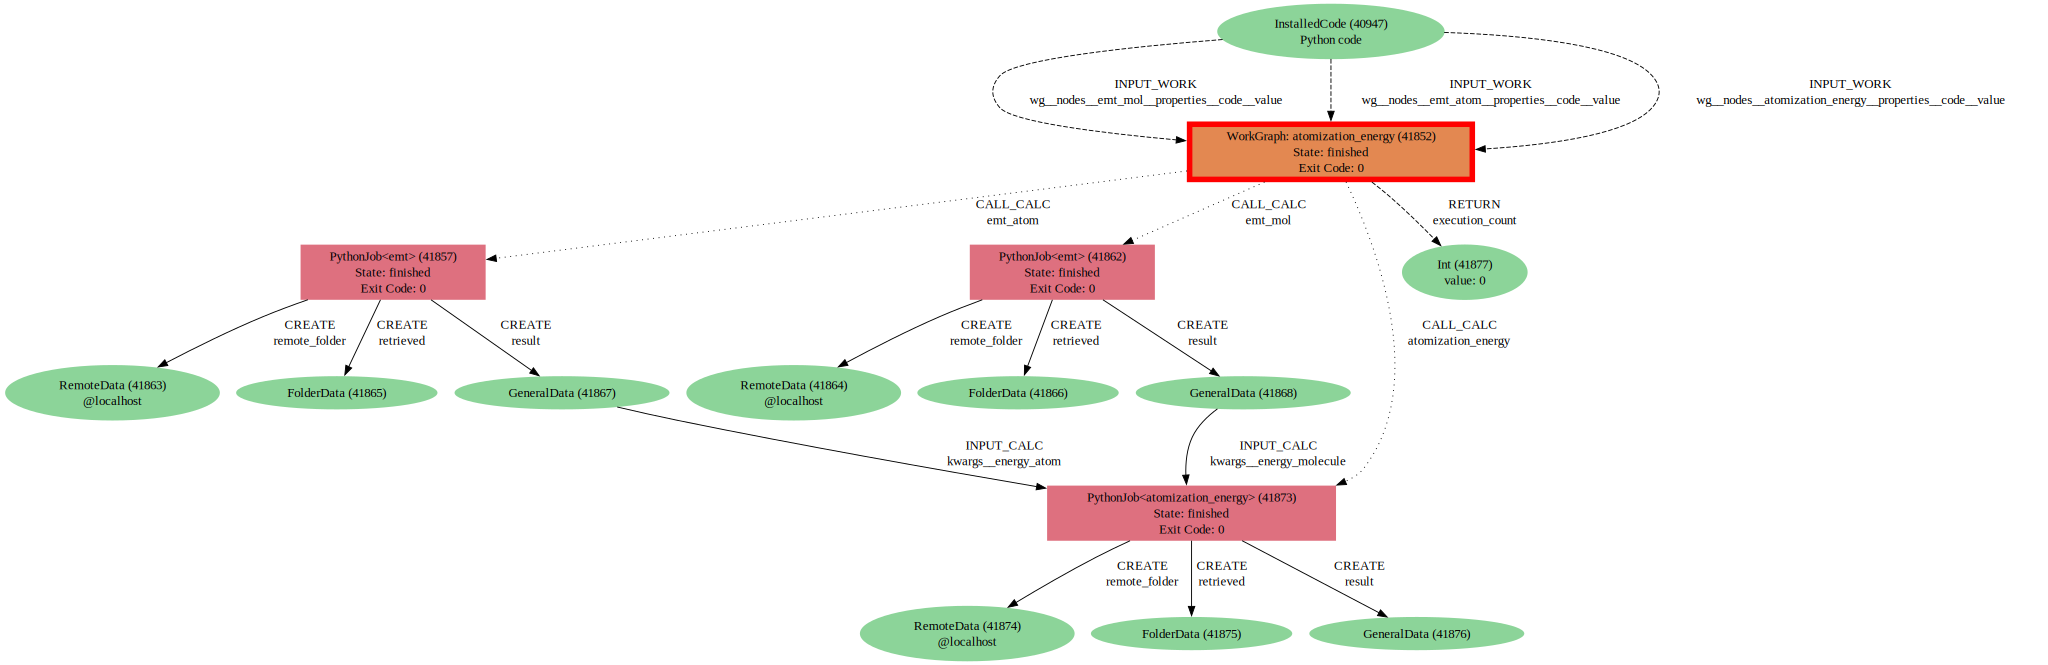

In [11]:
from ase.build import molecule
from ase import Atoms

load_profile()

code = load_code("python@localhost")
# create input structure node
n_atom = Atoms("N")
n_atom.center(vacuum=1.5)
n_atom.pbc = True
n2_molecule = molecule("N2")
n2_molecule.center(vacuum=5.0)
n2_molecule.pbc = True


#------------------------- Set the inputs -------------------------
wg.nodes["emt_atom"].set({"code": code,
                            "atoms": n_atom,
        })
wg.nodes["emt_mol"].set({"code": code,
                            "atoms": n2_molecule,
        })
wg.nodes["atomization_energy"].set({"code": code,
                                    "mol": n2_molecule,
        })
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.nodes['emt_atom'].outputs["result"].value.value))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.nodes['emt_mol'].outputs["result"].value.value))
print('Atomization energy:                  {:0.3f} eV'.format(wg.nodes['atomization_energy'].outputs["result"].value.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)


## Call shell commands in the PythonJob node

We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph and the `PythonJob` node, this can be run through AiiDA with the following workgraph:

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

WorkGraph node created, PK: 41878

Result of multiply is uuid: 7057ae41-c46b-4c4d-89c6-8dc367687e43 (pk: 41895) : 20.0 




/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


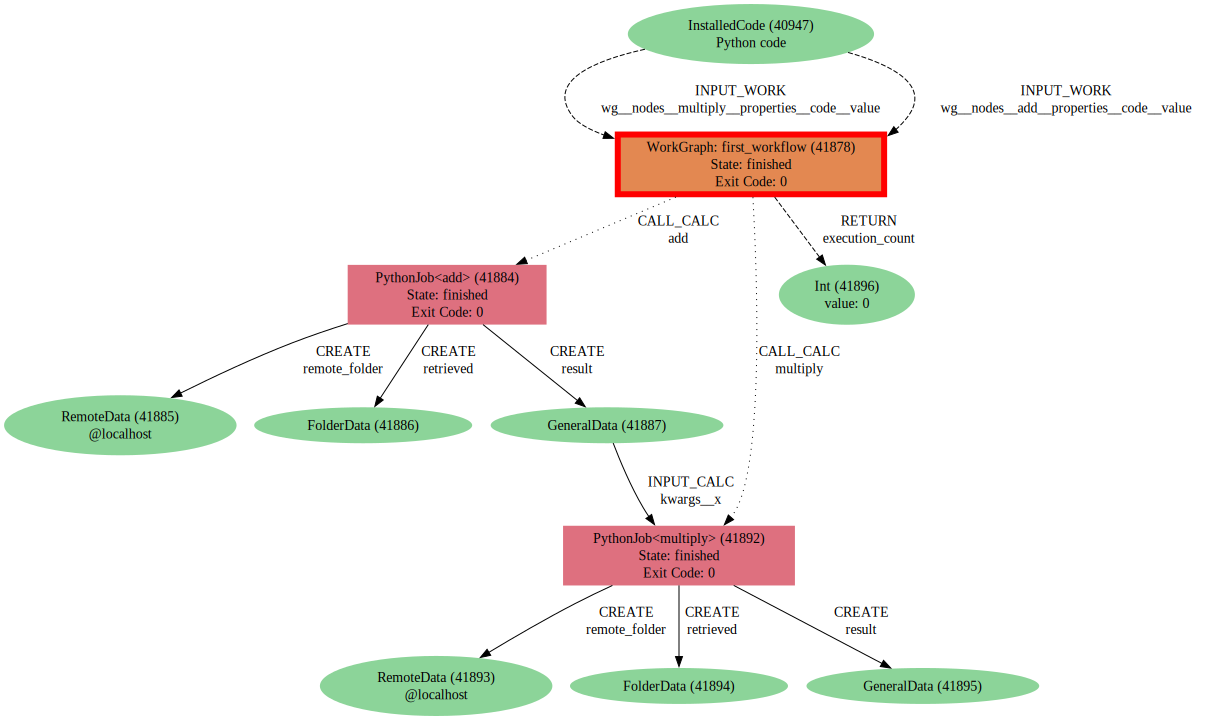

In [12]:
from aiida_workgraph import  node, WorkGraph

@node()
def add(x, y):
    import os
    os.system("echo '{} + {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


@node()
def multiply(x, y):
    import os
    os.system("echo '{} * {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


wg = WorkGraph("first_workflow")
wg.nodes.new("PythonJob", function=add, name="add")
wg.nodes.new("PythonJob", function=multiply, name="multiply", x=wg.nodes["add"].outputs[0])

# visualize the workgraph
display(wg)

code = load_code("python@localhost")

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "code": code},
                    "multiply": {"y": 4, "code": code}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## What's Next
